Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END .............clf__shrinkage=auto, clf__solver=eigen; total time=   0.0s
[CV] END .............clf__shrinkage=auto, clf__solver=eigen; total time=   0.0s
[CV] END ..............clf__shrinkage=auto, clf__solver=lsqr; total time=   0.0s
[CV] END ..............clf__shrinkage=auto, clf__solver=lsqr; total time=   0.0s
[CV] END .............clf__shrinkage=auto, clf__solver=eigen; total time=   0.0s
[CV] END ..............clf__shrinkage=auto, clf__solver=lsqr; total time=   0.0s
[CV] END ..............clf__shrinkage=auto, clf__solver=lsqr; total time=   0.0s
[CV] END ..............clf__shrinkage=auto, clf__solver=lsqr; total time=   0.0s
[CV] END .............clf__shrinkage=auto, clf__solver=eigen; total time=   0.0s
[CV] END .............clf__shrinkage=auto, clf__solver=eigen; total time=   0.0s
[CV] END ..............clf__shrinkage=None, clf__solver=lsqr; total time=   0.0s
[CV] END ..............clf__shrinkage=None, clf_

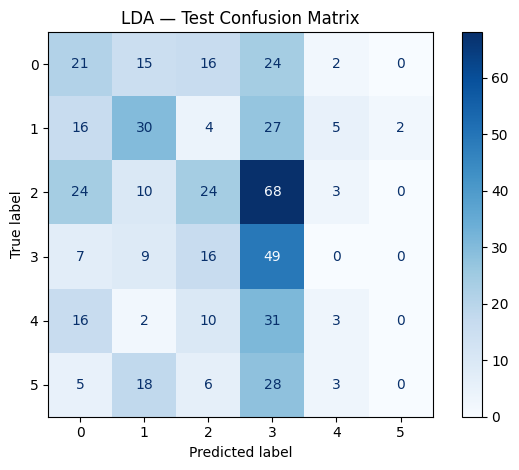

Test Set AUC (OvR): 0.6319

== Confidence Decile Table ==
      Top %  N Samples  Correct Predictions  Accuracy in Decile  \
0   Top 10%         49                   21               0.429   
1   Top 20%         98                   39               0.398   
2   Top 30%        148                   50               0.338   
3   Top 40%        197                   62               0.315   
4   Top 50%        247                   68               0.275   
5   Top 60%        296                   87               0.294   
6   Top 70%        345                  100               0.290   
7   Top 80%        395                  110               0.278   
8   Top 90%        444                  119               0.268   
9  Top 100%        494                  127               0.257   

   Avg Confidence  
0           0.586  
1           0.524  
2           0.485  
3           0.457  
4           0.434  
5           0.414  
6           0.397  
7           0.382  
8           0.367  
9   

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_auc_score
)

# -----------------------------
# 1. Load and Prepare Data
# -----------------------------
train_df = pd.read_csv("../data/generated_data/train.csv")
test_df = pd.read_csv("../data/generated_data/test.csv")

drop_cols = ["date"]
train_df = train_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")
test_df = test_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")

train_df['regime_today'] = train_df['regime']
test_df['regime_today'] = test_df['regime']

train_df['regime_t+3'] = train_df['regime'].shift(-3)
test_df['regime_t+3'] = test_df['regime'].shift(-3)

train_df = train_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])
test_df = test_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])

# -----------------------------
# 2. Feature / Target Split
# -----------------------------
X_train = train_df.drop(columns=['regime_t+3'])
y_train = train_df['regime_t+3'].astype(int) - 1
X_test = test_df.drop(columns=['regime_t+3'])
y_test = test_df['regime_t+3'].astype(int) - 1

# -----------------------------
# 3. Scale Features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4. LDA Optimization (Grid Search)
# -----------------------------
pipeline_lda = Pipeline([
    ('clf', LinearDiscriminantAnalysis())
])

param_grid_lda = {
    'clf__solver': ['lsqr', 'eigen'],
    'clf__shrinkage': ['auto', None, 0.1, 0.3, 0.5, 0.7, 0.9]
}

grid_lda = GridSearchCV(
    estimator=pipeline_lda,
    param_grid=param_grid_lda,
    scoring='roc_auc_ovr',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_lda.fit(X_train_scaled, y_train)

print("\n== Best LDA Params ==")
print(grid_lda.best_params_)
print(f"Best CV AUC (OvR): {grid_lda.best_score_:.4f}")

best_lda = grid_lda.best_estimator_

# -----------------------------
# 5. Evaluate on Test Set
# -----------------------------
y_pred_test = best_lda.predict(X_test_scaled)
y_test_proba = best_lda.predict_proba(X_test_scaled)

print("\n== LDA — TEST Accuracy Report ==")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap="Blues", values_format="d")
plt.title("LDA — Test Confusion Matrix")
plt.tight_layout()
plt.show()

# Calculate Test AUC
auc_score = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
print(f"Test Set AUC (OvR): {auc_score:.4f}")

# -----------------------------
# 6. Confidence-Based Decile Analysis
# -----------------------------
confidences = y_test_proba.max(axis=1)
y_pred = np.argmax(y_test_proba, axis=1)

eval_df = pd.DataFrame({
    "true": y_test + 1,  # reverse 0-indexing
    "pred": y_pred + 1,
    "conf": confidences
})

eval_df["correct"] = (eval_df["true"] == eval_df["pred"]).astype(int)
eval_df = eval_df.sort_values("conf", ascending=False).reset_index(drop=True)

decile_results = []
n = len(eval_df)
total_correct = eval_df["correct"].sum()

for d in range(10, 110, 10):  # Deciles: 10% to 100%
    cutoff = int((d / 100) * n)
    subset = eval_df.iloc[:cutoff]
    n_samples = len(subset)
    n_correct = subset["correct"].sum()
    accuracy = n_correct / n_samples if n_samples > 0 else 0
    avg_conf = subset["conf"].mean() if n_samples > 0 else 0

    decile_results.append({
        "Top %": f"Top {d}%",
        "N Samples": n_samples,
        "Correct Predictions": n_correct,
        "Accuracy in Decile": round(accuracy, 3),
        "Avg Confidence": round(avg_conf, 3)
    })

decile_df = pd.DataFrame(decile_results)
print("\n== Confidence Decile Table ==")
print(decile_df)
